# Anomaly Detection using PyOD


## Key Concepts
- **Anomaly (Outlier)**: Data points that deviate significantly from the majority
- **Univariate Detection**: Detecting anomalies in single variable data
- **Multivariate Detection**: Detecting anomalies considering multiple variables simultaneously


## 1. Install and Import Libraries

In [1]:
# Install PyOD if not already installed
!pip install pyod --quiet
!pip install suod --quiet  # For faster parallel processing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seed and plotting style
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
print("Base libraries imported successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 862.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Base libraries imported successfully!


In [2]:
# Import PyOD algorithms
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA as PCA_OD
from pyod.models.copod import COPOD
from pyod.models.ecod import ECOD
from pyod.utils.data import generate_data
from pyod.utils.example import visualize

print("PyOD algorithms imported successfully!")
import pyod
print(f"PyOD version: {pyod.__version__}")

PyOD algorithms imported successfully!
PyOD version: 2.0.6


## 2. Generate Synthetic Data with Anomalies

In [3]:
# Generate synthetic data with outliers using PyOD
contamination = 0.1  # 10% outliers
n_train = 500
n_test = 200

# Generate training and test data
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features=2,
    contamination=contamination,
    random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Contamination rate: {contamination*100}%")
print(f"Outliers in training: {y_train.sum()}")
print(f"Outliers in test: {y_test.sum()}")

Training set: (500, 2)
Test set: (200, 2)
Contamination rate: 10.0%
Outliers in training: 50.0
Outliers in test: 20.0


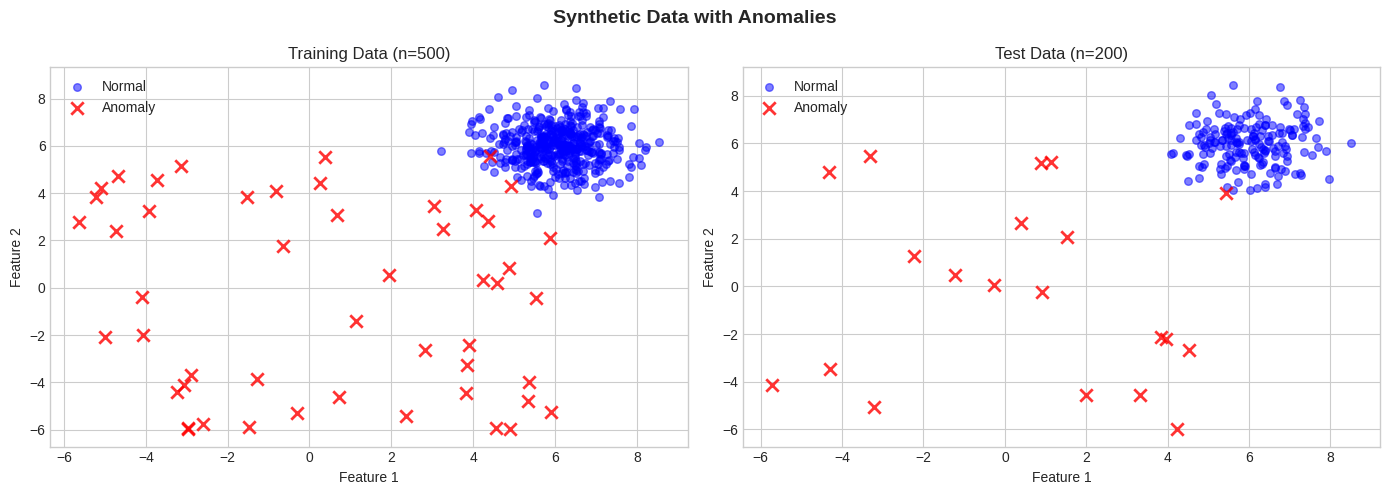

In [4]:
# Visualize the synthetic data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training data
axes[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
                c='blue', alpha=0.5, s=30, label='Normal')
axes[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
                c='red', alpha=0.8, s=80, marker='x', linewidths=2, label='Anomaly')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title(f'Training Data (n={n_train})')
axes[0].legend()

# Test data
axes[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1],
                c='blue', alpha=0.5, s=30, label='Normal')
axes[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1],
                c='red', alpha=0.8, s=80, marker='x', linewidths=2, label='Anomaly')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title(f'Test Data (n={n_test})')
axes[1].legend()

plt.suptitle('Synthetic Data with Anomalies', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Univariate Anomaly Detection

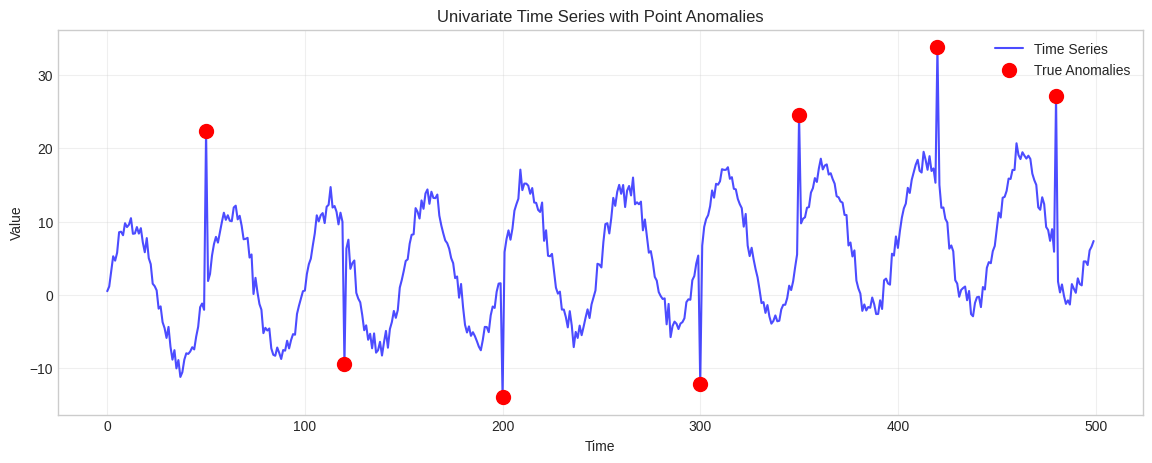

Total points: 500
Number of anomalies: 7


In [5]:
# Generate univariate time series data with anomalies
np.random.seed(42)

# Generate normal data with seasonal pattern
n_points = 500
time = np.arange(n_points)
seasonal = 10 * np.sin(2 * np.pi * time / 50)
trend = 0.02 * time
noise = np.random.normal(0, 1, n_points)
normal_data = seasonal + trend + noise

# Add point anomalies
data_with_anomalies = normal_data.copy()
anomaly_indices = [50, 120, 200, 300, 350, 420, 480]
for idx in anomaly_indices:
    data_with_anomalies[idx] += np.random.choice([-1, 1]) * np.random.uniform(15, 25)

# Create labels
y_univariate = np.zeros(n_points)
y_univariate[anomaly_indices] = 1

# Visualize
plt.figure(figsize=(14, 5))
plt.plot(time, data_with_anomalies, 'b-', alpha=0.7, label='Time Series')
plt.scatter(anomaly_indices, data_with_anomalies[anomaly_indices],
            c='red', s=100, marker='o', label='True Anomalies', zorder=5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Univariate Time Series with Point Anomalies')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total points: {n_points}")
print(f"Number of anomalies: {len(anomaly_indices)}")

In [6]:
# Apply anomaly detection algorithms to univariate data
# Reshape data for PyOD (requires 2D input)
X_univariate = data_with_anomalies.reshape(-1, 1)

# Initialize detectors
detectors = {
    'Isolation Forest': IForest(contamination=0.02, random_state=42),
    'Local Outlier Factor': LOF(contamination=0.02, n_neighbors=20),
    'One-Class SVM': OCSVM(contamination=0.02),
    'KNN': KNN(contamination=0.02, n_neighbors=10),
    'HBOS': HBOS(contamination=0.02),
    'COPOD': COPOD(contamination=0.02)
}

# Fit and predict
univariate_results = {}
for name, detector in detectors.items():
    detector.fit(X_univariate)
    predictions = detector.predict(X_univariate)
    scores = detector.decision_function(X_univariate)

    # Calculate metrics
    if y_univariate.sum() > 0:  # If we have true labels
        auc = roc_auc_score(y_univariate, scores)
        ap = average_precision_score(y_univariate, scores)
    else:
        auc, ap = 0, 0

    univariate_results[name] = {
        'predictions': predictions,
        'scores': scores,
        'auc': auc,
        'ap': ap
    }
    print(f"{name}: AUC = {auc:.3f}, AP = {ap:.3f}")

Isolation Forest: AUC = 0.999, AP = 0.928
Local Outlier Factor: AUC = 0.999, AP = 0.928
One-Class SVM: AUC = 0.999, AP = 0.948
KNN: AUC = 0.999, AP = 0.948
HBOS: AUC = 0.997, AP = 0.774
COPOD: AUC = 0.972, AP = 0.645


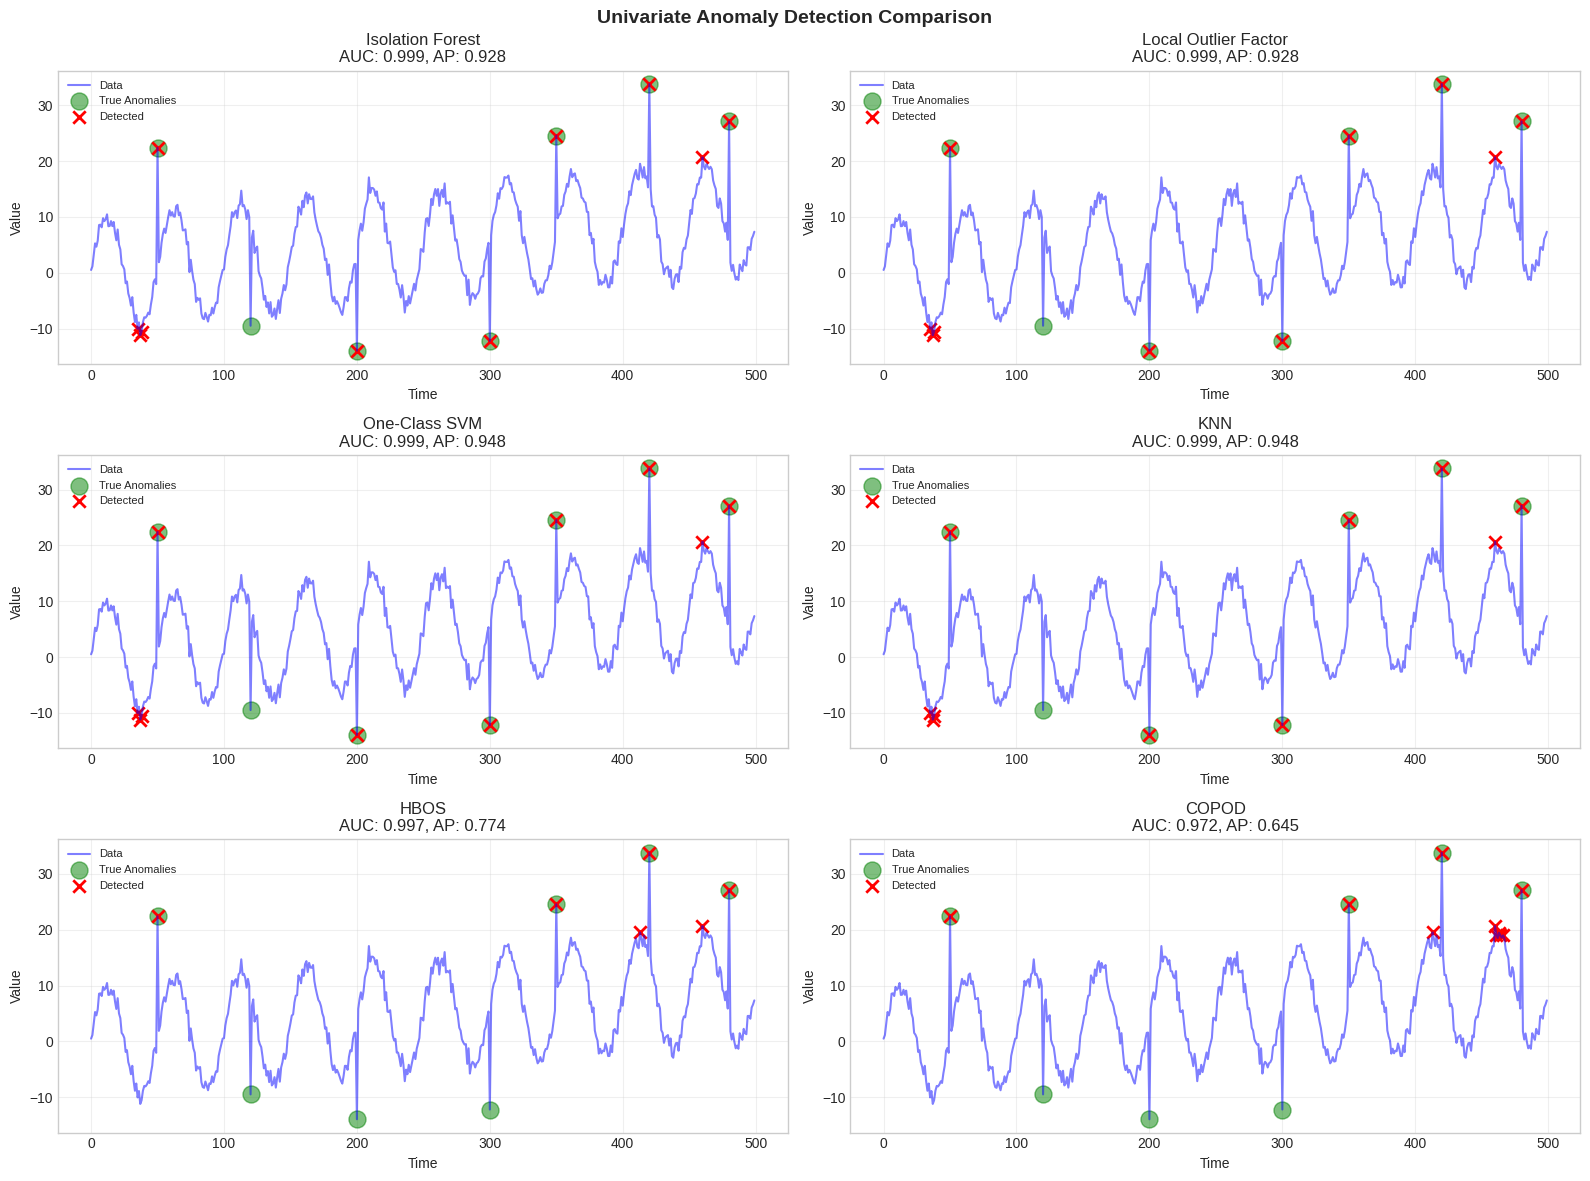

In [7]:
# Visualize anomaly detection results for univariate data
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(univariate_results.items()):
    # Plot time series
    axes[idx].plot(time, data_with_anomalies, 'b-', alpha=0.5, label='Data')

    # Plot true anomalies
    axes[idx].scatter(anomaly_indices, data_with_anomalies[anomaly_indices],
                      c='green', s=150, marker='o', alpha=0.5, label='True Anomalies')

    # Plot detected anomalies
    detected_idx = np.where(result['predictions'] == 1)[0]
    axes[idx].scatter(detected_idx, data_with_anomalies[detected_idx],
                      c='red', s=80, marker='x', linewidths=2, label='Detected')

    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Value')
    axes[idx].set_title(f"{name}\nAUC: {result['auc']:.3f}, AP: {result['ap']:.3f}")
    axes[idx].legend(loc='upper left', fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Univariate Anomaly Detection Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Multivariate Anomaly Detection

In [8]:
# Train and evaluate multiple detectors on multivariate data
multivariate_detectors = {
    'Isolation Forest': IForest(contamination=contamination, random_state=42),
    'LOF': LOF(contamination=contamination, n_neighbors=20),
    'One-Class SVM': OCSVM(contamination=contamination),
    'KNN': KNN(contamination=contamination, n_neighbors=10),
    'HBOS': HBOS(contamination=contamination),
    'PCA': PCA_OD(contamination=contamination),
    'COPOD': COPOD(contamination=contamination),
    'ECOD': ECOD(contamination=contamination)
}

multivariate_results = {}

print("Multivariate Anomaly Detection Results:")
print("="*60)

for name, detector in multivariate_detectors.items():
    # Train on training data
    detector.fit(X_train)

    # Predict on test data
    y_pred = detector.predict(X_test)
    scores = detector.decision_function(X_test)

    # Calculate metrics
    auc = roc_auc_score(y_test, scores)
    ap = average_precision_score(y_test, scores)

    multivariate_results[name] = {
        'predictions': y_pred,
        'scores': scores,
        'auc': auc,
        'ap': ap
    }

    print(f"{name:20s}: AUC = {auc:.4f}, AP = {ap:.4f}")

print("="*60)

Multivariate Anomaly Detection Results:
Isolation Forest    : AUC = 0.9956, AP = 0.9778
LOF                 : AUC = 0.7733, AP = 0.4377
One-Class SVM       : AUC = 0.9981, AP = 0.9870
KNN                 : AUC = 0.9981, AP = 0.9870
HBOS                : AUC = 0.9931, AP = 0.9411
PCA                 : AUC = 0.9642, AP = 0.9567
COPOD               : AUC = 0.9983, AP = 0.9875
ECOD                : AUC = 0.9450, AP = 0.6388


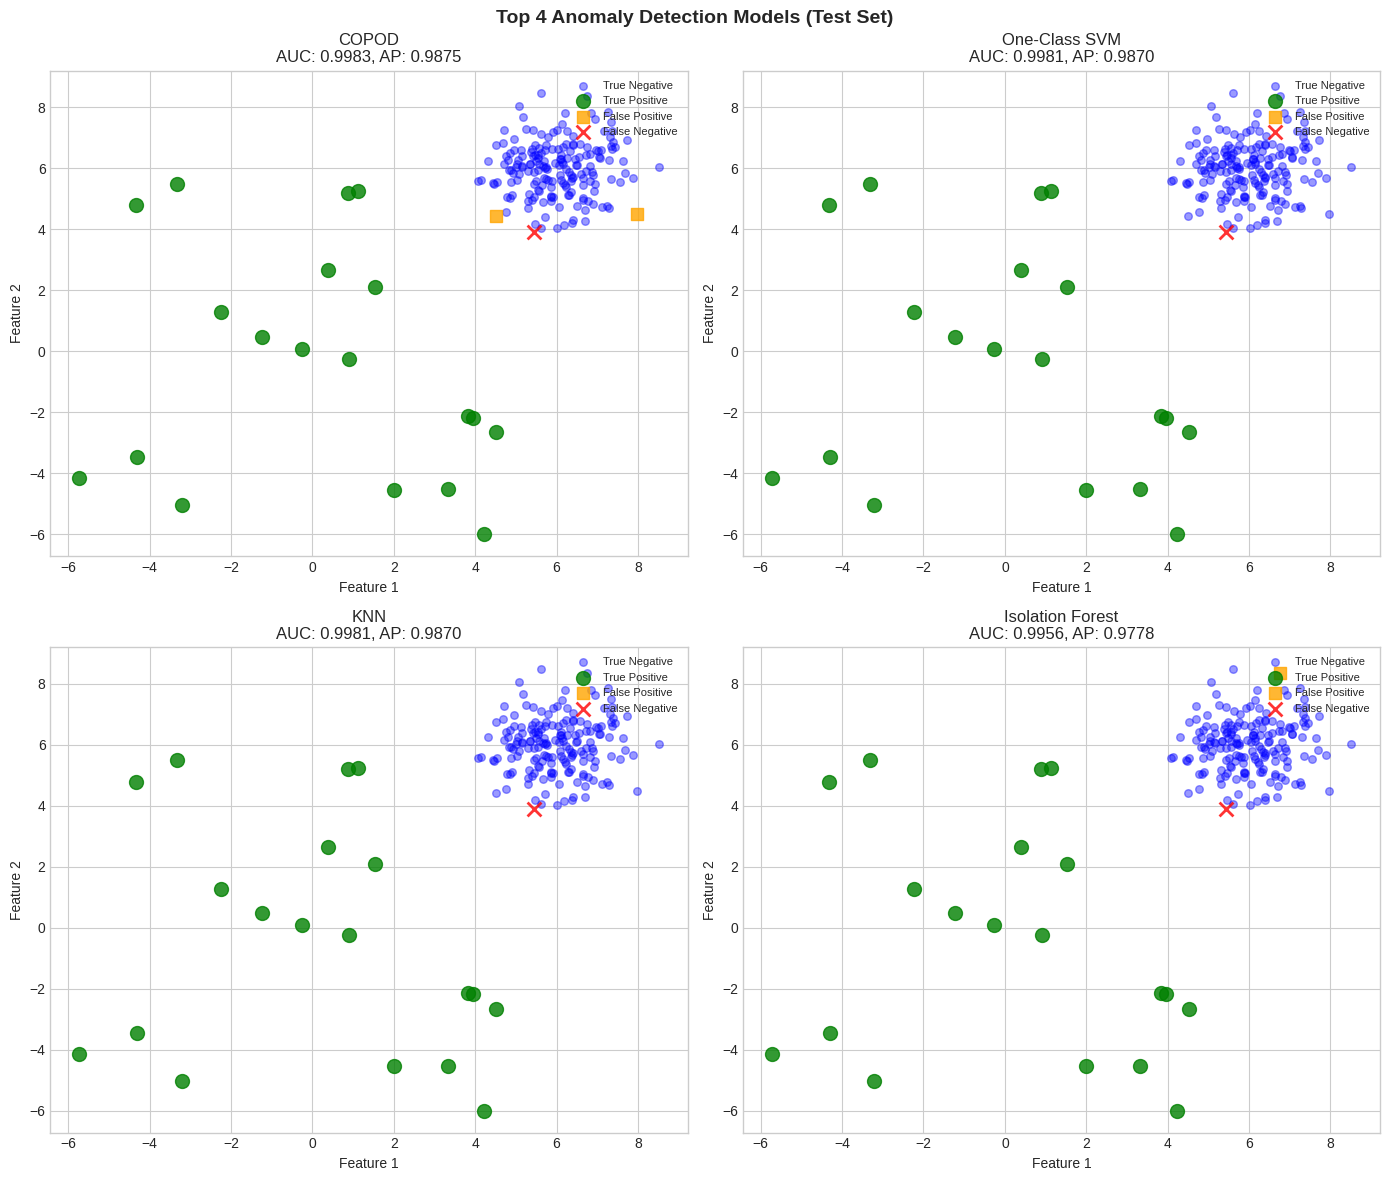

In [9]:
# Visualize results for top 4 models
# Sort by AUC
sorted_models = sorted(multivariate_results.items(), key=lambda x: x[1]['auc'], reverse=True)[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(sorted_models):
    y_pred = result['predictions']

    # True negatives (normal correctly classified)
    tn_mask = (y_test == 0) & (y_pred == 0)
    # True positives (anomalies correctly detected)
    tp_mask = (y_test == 1) & (y_pred == 1)
    # False positives (normal classified as anomaly)
    fp_mask = (y_test == 0) & (y_pred == 1)
    # False negatives (anomalies missed)
    fn_mask = (y_test == 1) & (y_pred == 0)

    axes[idx].scatter(X_test[tn_mask, 0], X_test[tn_mask, 1], c='blue',
                      alpha=0.4, s=30, label='True Negative')
    axes[idx].scatter(X_test[tp_mask, 0], X_test[tp_mask, 1], c='green',
                      alpha=0.8, s=100, marker='o', label='True Positive')
    axes[idx].scatter(X_test[fp_mask, 0], X_test[fp_mask, 1], c='orange',
                      alpha=0.8, s=80, marker='s', label='False Positive')
    axes[idx].scatter(X_test[fn_mask, 0], X_test[fn_mask, 1], c='red',
                      alpha=0.8, s=100, marker='x', linewidths=2, label='False Negative')

    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')
    axes[idx].set_title(f"{name}\nAUC: {result['auc']:.4f}, AP: {result['ap']:.4f}")
    axes[idx].legend(loc='upper right', fontsize=8)

plt.suptitle('Top 4 Anomaly Detection Models (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. ROC and Precision-Recall Curves

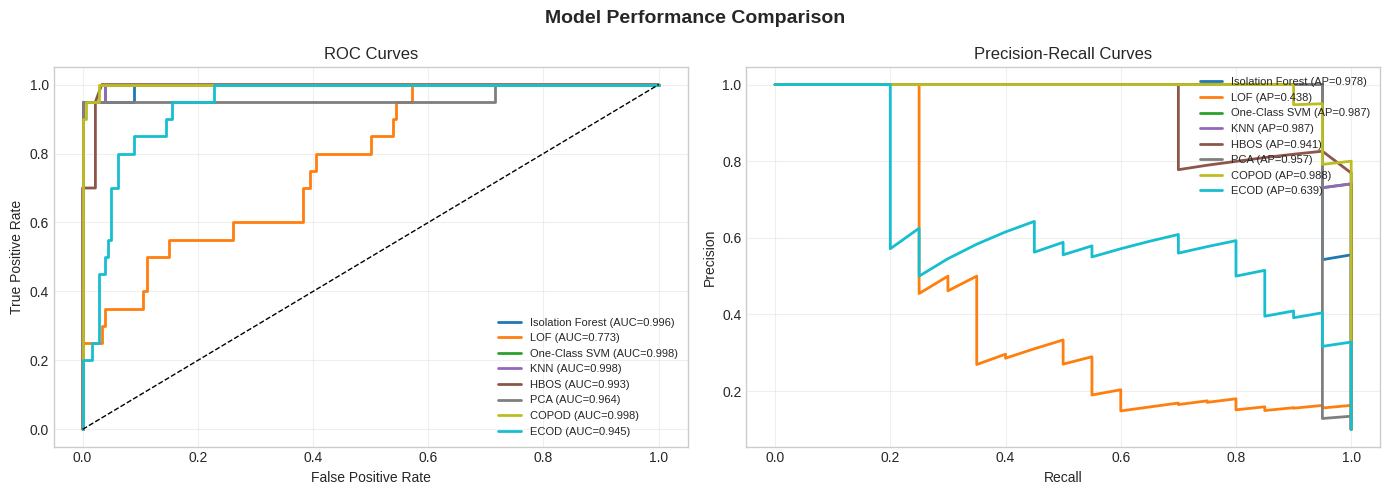

In [10]:
# Plot ROC curves for all models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.tab10(np.linspace(0, 1, len(multivariate_results)))

# ROC Curve
for (name, result), color in zip(multivariate_results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, result['scores'])
    axes[0].plot(fpr, tpr, color=color, linewidth=2,
                 label=f"{name} (AUC={result['auc']:.3f})")

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc='lower right', fontsize=8)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
for (name, result), color in zip(multivariate_results.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, result['scores'])
    axes[1].plot(recall, precision, color=color, linewidth=2,
                 label=f"{name} (AP={result['ap']:.3f})")

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Anomaly Scores Distribution

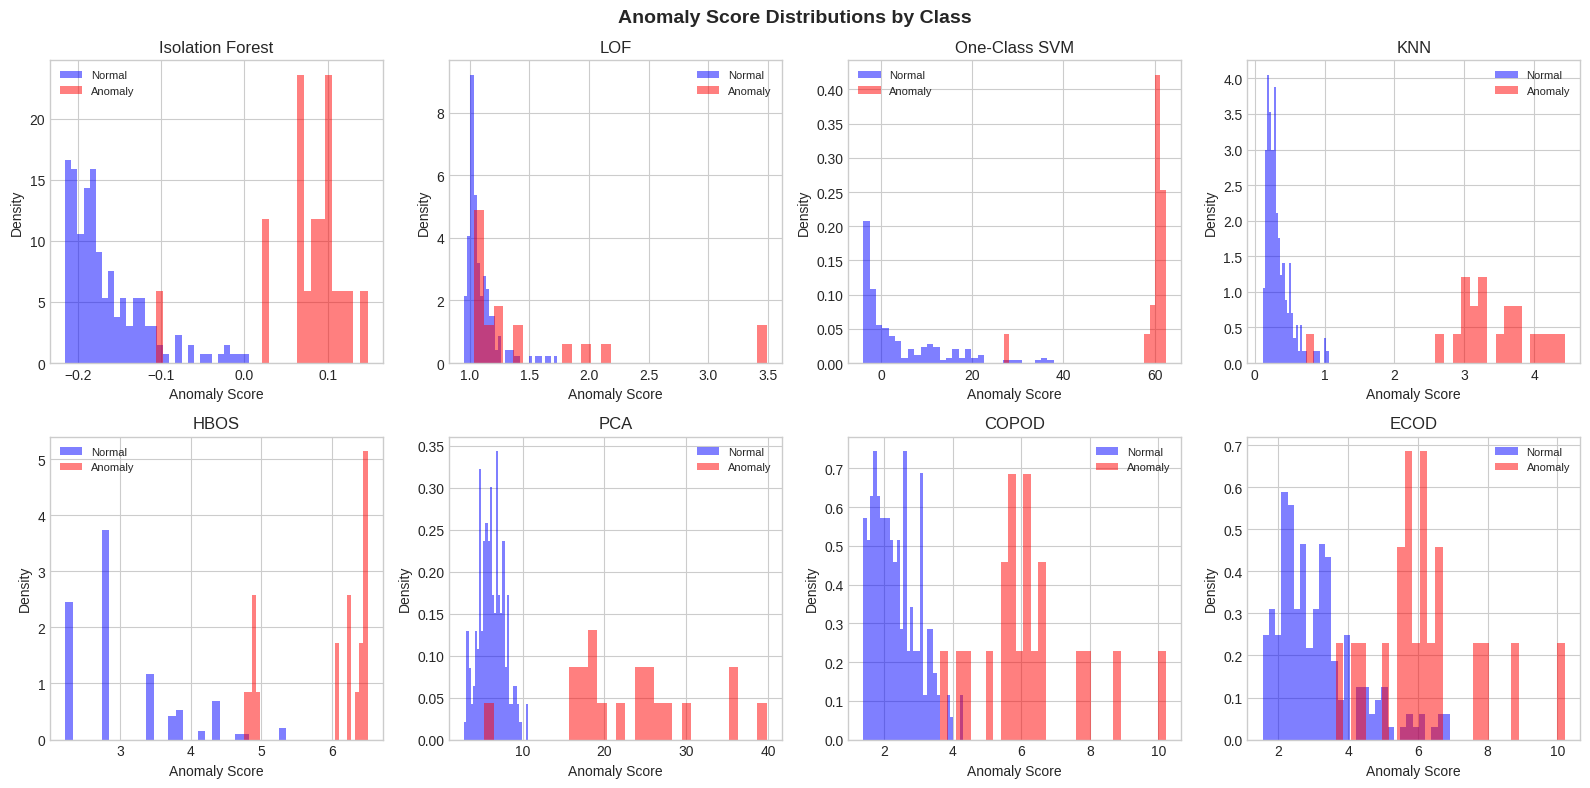


Good separation between distributions indicates better anomaly detection.


In [11]:
# Visualize anomaly score distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, result) in enumerate(multivariate_results.items()):
    scores = result['scores']

    # Plot distribution for normal and anomaly points
    normal_scores = scores[y_test == 0]
    anomaly_scores = scores[y_test == 1]

    axes[idx].hist(normal_scores, bins=30, alpha=0.5, color='blue', label='Normal', density=True)
    axes[idx].hist(anomaly_scores, bins=30, alpha=0.5, color='red', label='Anomaly', density=True)
    axes[idx].set_xlabel('Anomaly Score')
    axes[idx].set_ylabel('Density')
    axes[idx].set_title(f'{name}')
    axes[idx].legend(fontsize=8)

plt.suptitle('Anomaly Score Distributions by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nGood separation between distributions indicates better anomaly detection.")

## 7. Real-World Use Case: Credit Card Fraud Detection

In [12]:
# Simulate credit card transaction data
np.random.seed(42)

n_normal = 2000
n_fraud = 50

# Normal transactions (clustered)
normal_amount = np.random.exponential(50, n_normal)  # Average transaction ~$50
normal_frequency = np.random.normal(10, 3, n_normal)  # ~10 transactions per month
normal_time = np.random.uniform(8, 22, n_normal)  # Regular hours

# Fraudulent transactions (unusual patterns)
fraud_amount = np.random.exponential(500, n_fraud)  # Much higher amounts
fraud_frequency = np.random.normal(40, 10, n_fraud)  # Very high frequency
fraud_time = np.random.uniform(0, 24, n_fraud)  # Any time including unusual hours

# Combine data
X_fraud = np.vstack([
    np.column_stack([normal_amount, normal_frequency, normal_time]),
    np.column_stack([fraud_amount, fraud_frequency, fraud_time])
])

y_fraud = np.concatenate([np.zeros(n_normal), np.ones(n_fraud)])

# Shuffle
shuffle_idx = np.random.permutation(len(y_fraud))
X_fraud = X_fraud[shuffle_idx]
y_fraud = y_fraud[shuffle_idx]

# Create DataFrame
fraud_df = pd.DataFrame(X_fraud, columns=['Amount', 'Frequency', 'Hour'])
fraud_df['Label'] = y_fraud.astype(int)

print("Credit Card Transaction Dataset:")
print(fraud_df.describe())
print(f"\nFraud rate: {y_fraud.sum()/len(y_fraud)*100:.2f}%")

Credit Card Transaction Dataset:
            Amount    Frequency         Hour        Label
count  2050.000000  2050.000000  2050.000000  2050.000000
mean     62.529790    10.727257    14.907025     0.024390
std     132.471073     5.557111     4.145167     0.154295
min       0.161173     0.941464     0.872178     0.000000
25%      13.863088     8.070898    11.411939     0.000000
50%      36.511748    10.102890    14.851840     0.000000
75%      72.379752    12.188041    18.489750     0.000000
max    3271.836226    63.817135    22.477685     1.000000

Fraud rate: 2.44%


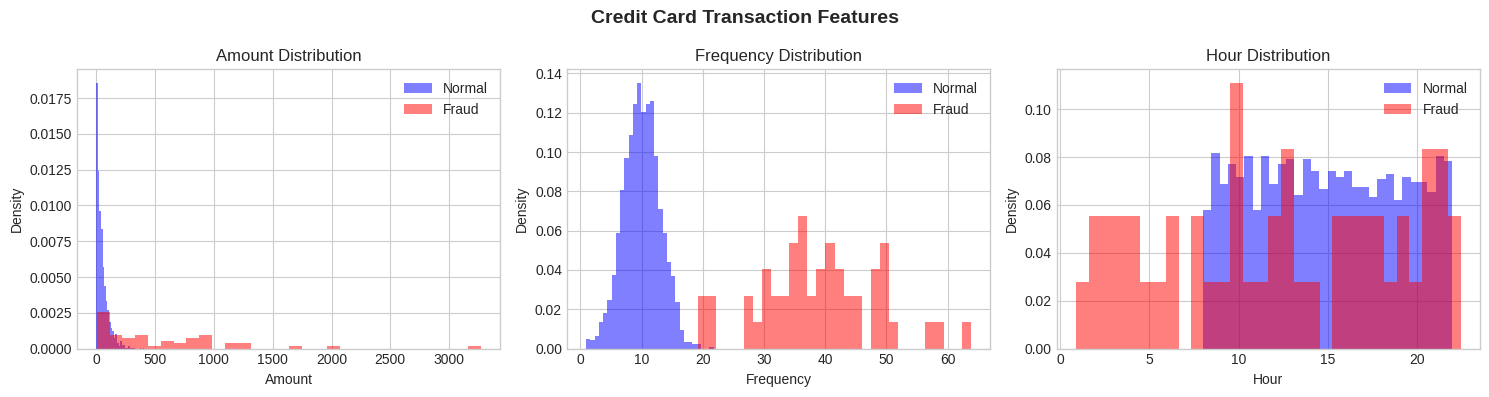

In [13]:
# Visualize the fraud dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

features = ['Amount', 'Frequency', 'Hour']
for idx, feat in enumerate(features):
    normal_data = fraud_df[fraud_df['Label'] == 0][feat]
    fraud_data = fraud_df[fraud_df['Label'] == 1][feat]

    axes[idx].hist(normal_data, bins=30, alpha=0.5, color='blue', label='Normal', density=True)
    axes[idx].hist(fraud_data, bins=30, alpha=0.5, color='red', label='Fraud', density=True)
    axes[idx].set_xlabel(feat)
    axes[idx].set_ylabel('Density')
    axes[idx].set_title(f'{feat} Distribution')
    axes[idx].legend()

plt.suptitle('Credit Card Transaction Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# Apply anomaly detection to fraud data
# Preprocess
scaler = StandardScaler()
X_fraud_scaled = scaler.fit_transform(X_fraud)

# Split data
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud_scaled, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)

# Calculate contamination from training data
fraud_contamination = y_train_fraud.sum() / len(y_train_fraud)

# Define detectors
fraud_detectors = {
    'Isolation Forest': IForest(contamination=fraud_contamination, random_state=42),
    'LOF': LOF(contamination=fraud_contamination, n_neighbors=20),
    'COPOD': COPOD(contamination=fraud_contamination),
    'ECOD': ECOD(contamination=fraud_contamination)
}

# Train and evaluate
print("Fraud Detection Results:")
print("="*60)

fraud_results = {}
for name, detector in fraud_detectors.items():
    detector.fit(X_train_fraud)
    y_pred = detector.predict(X_test_fraud)
    scores = detector.decision_function(X_test_fraud)

    auc = roc_auc_score(y_test_fraud, scores)
    ap = average_precision_score(y_test_fraud, scores)

    fraud_results[name] = {'predictions': y_pred, 'scores': scores, 'auc': auc, 'ap': ap}
    print(f"{name:20s}: AUC = {auc:.4f}, AP = {ap:.4f}")

print("="*60)

Fraud Detection Results:
Isolation Forest    : AUC = 0.9937, AP = 0.9164
LOF                 : AUC = 0.9229, AP = 0.4347
COPOD               : AUC = 0.9841, AP = 0.8597
ECOD                : AUC = 0.9634, AP = 0.8198



Best Model: Isolation Forest
AUC: 0.9937

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       600
       Fraud       1.00      0.87      0.93        15

    accuracy                           1.00       615
   macro avg       1.00      0.93      0.96       615
weighted avg       1.00      1.00      1.00       615



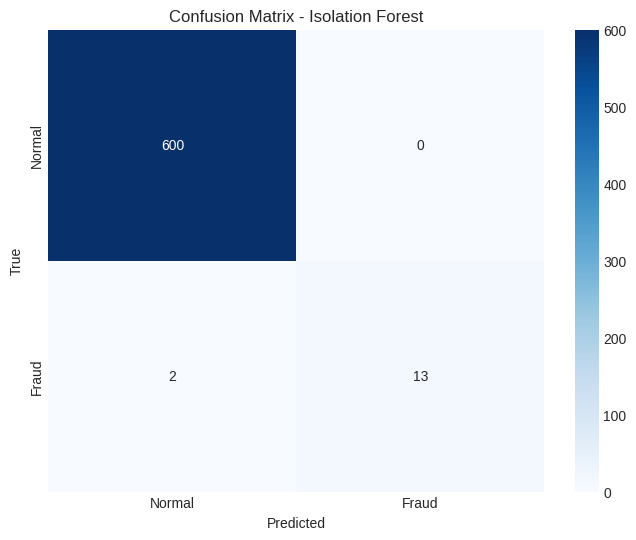

In [15]:
# Detailed evaluation for best model
best_model = max(fraud_results.items(), key=lambda x: x[1]['auc'])
print(f"\nBest Model: {best_model[0]}")
print(f"AUC: {best_model[1]['auc']:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_fraud, best_model[1]['predictions'],
                           target_names=['Normal', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test_fraud, best_model[1]['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model[0]}')
plt.show()

## 8. Ensemble Anomaly Detection

In [16]:
# Combine multiple detectors for ensemble prediction
from pyod.models.combination import average, maximization, aom, moa

# Get scores from all models
all_scores = np.column_stack([result['scores'] for result in multivariate_results.values()])

# Different combination methods
ensemble_methods = {
    'Average': average(all_scores),
    'Maximum': maximization(all_scores),
    'AOM (Average of Maximum)': aom(all_scores, n_buckets=4),
    'MOA (Maximum of Average)': moa(all_scores, n_buckets=4)
}

print("Ensemble Anomaly Detection Results:")
print("="*50)

for name, scores in ensemble_methods.items():
    auc = roc_auc_score(y_test, scores)
    ap = average_precision_score(y_test, scores)
    print(f"{name:25s}: AUC = {auc:.4f}, AP = {ap:.4f}")

print("="*50)
print("\nEnsemble methods often outperform individual detectors!")

Ensemble Anomaly Detection Results:
Average                  : AUC = 0.9981, AP = 0.9870
Maximum                  : AUC = 0.9981, AP = 0.9870
AOM (Average of Maximum) : AUC = 0.9981, AP = 0.9870
MOA (Maximum of Average) : AUC = 0.9981, AP = 0.9870

Ensemble methods often outperform individual detectors!


## 9. Quality Metrics Summary

In [17]:
# Create comprehensive metrics summary
metrics_summary = []

for name, result in multivariate_results.items():
    y_pred = result['predictions']
    y_scores = result['scores']

    # Calculate various metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    metrics_summary.append({
        'Model': name,
        'AUC-ROC': result['auc'],
        'Average Precision': result['ap'],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'True Positives': tp,
        'False Positives': fp
    })

metrics_df = pd.DataFrame(metrics_summary)
metrics_df = metrics_df.sort_values('AUC-ROC', ascending=False).reset_index(drop=True)

print("\nAnomaly Detection Quality Metrics Summary:")
print("="*100)
print(metrics_df.to_string(index=False))
print("="*100)


Anomaly Detection Quality Metrics Summary:
           Model  AUC-ROC  Average Precision  Precision  Recall  F1-Score  True Positives  False Positives
           COPOD 0.998333           0.987500   0.904762    0.95  0.926829              19                2
             KNN 0.998056           0.987037   1.000000    0.95  0.974359              19                0
   One-Class SVM 0.998056           0.987037   1.000000    0.95  0.974359              19                0
Isolation Forest 0.995556           0.977778   0.950000    0.95  0.950000              19                1
            HBOS 0.993056           0.941101   0.826087    0.95  0.883721              19                4
             PCA 0.964167           0.956711   1.000000    0.95  0.974359              19                0
            ECOD 0.945000           0.638806   0.583333    0.70  0.636364              14               10
             LOF 0.773333           0.437732   0.388889    0.35  0.368421               7           

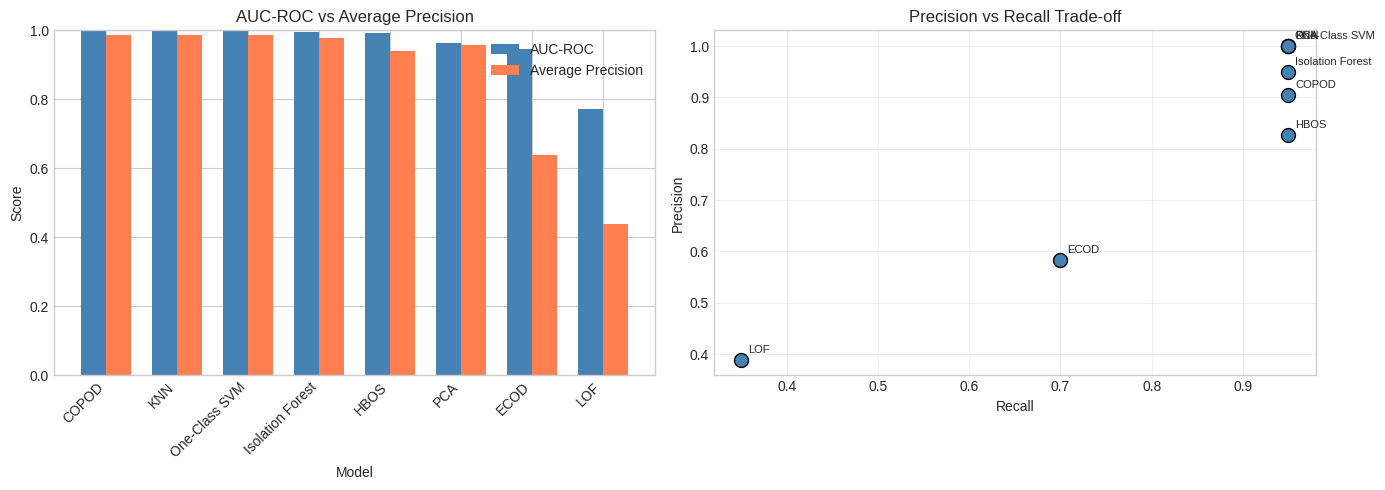

In [18]:
# Visualize metrics comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for AUC and AP
x = np.arange(len(metrics_df))
width = 0.35

axes[0].bar(x - width/2, metrics_df['AUC-ROC'], width, label='AUC-ROC', color='steelblue')
axes[0].bar(x + width/2, metrics_df['Average Precision'], width, label='Average Precision', color='coral')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('AUC-ROC vs Average Precision')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1])

# Precision vs Recall scatter
axes[1].scatter(metrics_df['Recall'], metrics_df['Precision'], s=100, c='steelblue', edgecolors='black')
for i, model in enumerate(metrics_df['Model']):
    axes[1].annotate(model, (metrics_df['Recall'].iloc[i], metrics_df['Precision'].iloc[i]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs Recall Trade-off')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

In [19]:
print("="*70)
print("ANOMALY DETECTION WITH PyOD - SUMMARY")
print("="*70)

print("\n1. ALGORITHMS USED:")
print("   - Isolation Forest: Tree-based isolation")
print("   - LOF: Local density-based detection")
print("   - One-Class SVM: Boundary-based detection")
print("   - KNN: Distance-based detection")
print("   - HBOS: Histogram-based detection")
print("   - COPOD: Copula-based detection")
print("   - ECOD: Empirical CDF-based detection")

print("\n2. USE CASES DEMONSTRATED:")
print("   - Univariate time series anomaly detection")
print("   - Multivariate point anomaly detection")
print("   - Credit card fraud detection (real-world simulation)")
print("   - Ensemble anomaly detection")

print("\n3. QUALITY METRICS USED:")
print("   - AUC-ROC: Area Under ROC Curve")
print("   - Average Precision: Precision-Recall AUC")
print("   - Precision: Correctly identified anomalies / Total detected")
print("   - Recall: Correctly identified anomalies / Total anomalies")
print("   - F1-Score: Harmonic mean of Precision and Recall")

print("\n4. KEY FINDINGS:")
best_model_name = metrics_df.iloc[0]['Model']
best_auc = metrics_df.iloc[0]['AUC-ROC']
print(f"   - Best performing model: {best_model_name} (AUC: {best_auc:.4f})")
print("   - Ensemble methods can improve detection performance")
print("   - Different algorithms suit different data characteristics")

print("\n5. RECOMMENDATIONS:")
print("   - Use multiple algorithms and compare results")
print("   - Consider ensemble methods for robust detection")
print("   - Tune contamination parameter based on domain knowledge")
print("   - Evaluate using multiple metrics, not just AUC")

print("\n" + "="*70)

ANOMALY DETECTION WITH PyOD - SUMMARY

1. ALGORITHMS USED:
   - Isolation Forest: Tree-based isolation
   - LOF: Local density-based detection
   - One-Class SVM: Boundary-based detection
   - KNN: Distance-based detection
   - HBOS: Histogram-based detection
   - COPOD: Copula-based detection
   - ECOD: Empirical CDF-based detection

2. USE CASES DEMONSTRATED:
   - Univariate time series anomaly detection
   - Multivariate point anomaly detection
   - Credit card fraud detection (real-world simulation)
   - Ensemble anomaly detection

3. QUALITY METRICS USED:
   - AUC-ROC: Area Under ROC Curve
   - Average Precision: Precision-Recall AUC
   - Precision: Correctly identified anomalies / Total detected
   - Recall: Correctly identified anomalies / Total anomalies
   - F1-Score: Harmonic mean of Precision and Recall

4. KEY FINDINGS:
   - Best performing model: COPOD (AUC: 0.9983)
   - Ensemble methods can improve detection performance
   - Different algorithms suit different data charac